In [1]:
## Necessary imports

import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process
from skopt.learning import ExtraTreesRegressor
from skopt import Optimizer
from file_paths_and_consts import *
import os
import geopandas as gpd
import pandas as pd
import json
import sys
import argparse
import warnings
import pickle
import json
import pickle
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process

from notebook_utils import *
warnings.filterwarnings('ignore')

## POLAND RETURN DATA

In [2]:
## reading ground truth data
geo_shp_file = BASE_DIR+'raw_data/UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp'
ukr_gdf = gpd.read_file(geo_shp_file)
all_raions = ukr_gdf['ADM2_EN'].tolist()
print('regions read..',flush=True)
## poland gt data
pl_border_data = pd.read_csv('poland_border_movement_utf8.csv',thousands=',')
#ukr_people_arrive_poland_by_date = ukr_people_arrive_poland_by_date.dropna(subset=['Total'])
pl_border_data['Date'] = pd.to_datetime(pl_border_data['Date'])
ukr_people_arrive_poland_by_date = ((pl_border_data[(pl_border_data.Direction=='Arrival to Poland') & (pl_border_data['Citizenship (Code)']=='UA')]).groupby('Date')['Total'].sum()).reset_index()
ukr_people_arrive_poland_by_date = ukr_people_arrive_poland_by_date.sort_values(by='Date')
ukr_people_depart_poland_by_date = ((pl_border_data[(pl_border_data.Direction=='Departure from Poland') & (pl_border_data['Citizenship (Code)']=='UA')]).groupby('Date')['Total'].sum()).reset_index()
ukr_people_depart_poland_by_date = ukr_people_depart_poland_by_date.sort_values(by='Date')
ukr_people_arrive_poland_by_date['Total'] = ukr_people_arrive_poland_by_date['Total'].rolling(15).mean()
ukr_people_depart_poland_by_date['Total'] = ukr_people_depart_poland_by_date['Total'].rolling(15).mean()
ukr_people_arrive_poland_by_date = ukr_people_arrive_poland_by_date.dropna(subset='Total')
ukr_people_depart_poland_by_date = ukr_people_depart_poland_by_date.dropna(subset='Total')
ukr_people_arrive_poland_by_date =  ukr_people_arrive_poland_by_date.rename(columns={'Date':'return_date','Total':'arrival'})
ukr_people_depart_poland_by_date =  ukr_people_depart_poland_by_date.rename(columns={'Date':'return_date','Total':'departure'})

regions read..


ERROR 1: PROJ: proj_create_from_database: Open of /home/zm8bh/.conda/envs/migration_env/share/proj failed


## SLOVAKIA RETURN DATA

In [3]:
with open('/project/biocomplexity/UKR_forecast/migration_data/gtruth_from_various_source/slovak_border_movement.json', 'r') as file:
    data = json.load(file)

# Print the data
df = pd.DataFrame.from_dict(data['data']['timeseries'])
df['data_date'] = pd.to_datetime(df['data_date'])
df = df[df.data_date<=pd.to_datetime('2022-08-01')]
df['individuals'] = df['individuals'].rolling(15).mean()
df = df.dropna(subset='individuals')
svk_ukr_depart_df = df.copy()
svk_ukr_depart_df = svk_ukr_depart_df.rename(columns={'data_date':'return_date','individuals':'departure'})


## ROMANIA RETURN DATA

In [4]:
# rom_ukr_depart_df = pd.read_csv('romania_border_exit_ukr.csv')
# rom_ukr_depart_df['return_date'] = pd.to_datetime(rom_ukr_depart_df['return_date'])
# rom_ukr_depart_df.replace(',','', regex=True, inplace=True)
# rom_ukr_depart_df['departure'] = rom_ukr_depart_df['departure'].apply(pd.to_numeric,errors='coerce')
# rom_ukr_depart_df['departure'] = rom_ukr_depart_df['departure'].rolling(15).mean()
# rom_ukr_depart_df = rom_ukr_depart_df.dropna(subset='departure')

## Top K Model Selection from current calibration state for different models

[88]
[40]
[115]
[64]
[53]
[85]
[69]


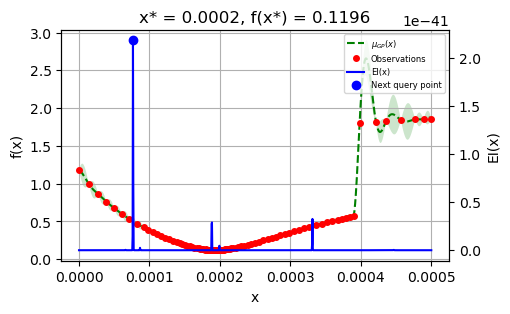

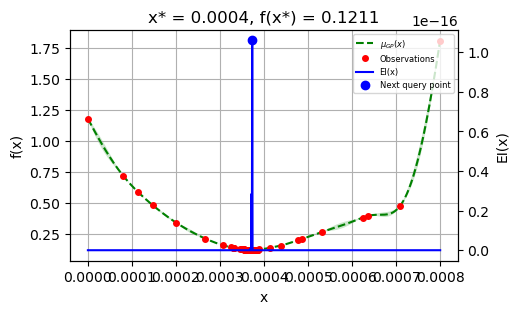

In [5]:
TOPK = 1

labels = []
min_observe_idx = []
dir_name = []

ftypes = ['constant','constant_global_conflict_lagged_21_intensity',
          'constant_global_conflict_intensity_peer_lagged_21',
          'constant_global_conflict_intensity_kmax_rolling_7_lagged_30_peer',
          'constant_global_conflict_intensity_kmax_rolling_7_lagged_35_peer',
          'constant_global_conflict_intensity_kmax_rolling_7_lagged_40_peer',
          'constant_global_conflict_intensity_kmax_rolling_7_lagged_45_peer']
modeltypes = ['ConstHaz','$GC_{21}^{14}$','$GC_{21}^{14}-Peer$','$GC_{30}^{7}-Peer$'
              ,'$GC_{35}^{7}-Peer$','$GC_{40}^{7}-Peer$','$GC_{45}^{7}-Peer$']

opts = []


for idx,ftype in enumerate(ftypes):
    modeltype = modeltypes[idx]
    
    optimizer_name = f'optimizers/return-optimizer-Bayesian_opt3-{ftype}.pkl'
    dirs = f'RETURN_HAZARD_Bayesian_opt3_{ftype}'
    
    with open(optimizer_name, 'rb') as f:
        opt = pickle.load(f)
    
    xs = opt.get_result()['x_iters']
    ys = opt.get_result()['func_vals']

    labels.append(modeltype)
    min_observe = findminobservation_idx(xs,ys,k=TOPK)
    print(min_observe)
    opts.append(np.array(xs)[min_observe])
    min_observe_idx.append(min_observe)
    dir_name.append(dirs)

    if len(xs[0])==1:    
        plot_args = {"show_legend": True,"show_title": True, "show_next_point": True,"show_acq_func": True}
        fig, ax = plt.subplots(figsize=(5,3))
        plot_gaussian_process(opt.get_result(),ax=ax, **plot_args)


## 4 demographic case study test

In [6]:
arr_x = np.load('surrogates/surrogate_case_study_results/return-optimizer-bayes-demo4-surrrogate-const-1-x')
arr_y = np.load('surrogates/surrogate_case_study_results/return-optimizer-bayes-demo4-surrrogate-const-1-y')

In [7]:
arr_x

array([[0.00016657, 0.00083839, 0.00085296, 0.00043627],
       [0.00028848, 0.00013898, 0.00062898, 0.00010796],
       [0.00043666, 0.00056946, 0.0007364 , 0.00061472],
       ...,
       [0.00076633, 0.00027874, 0.00026482, 0.00030427],
       [0.0003989 , 0.00021932, 0.00026721, 0.00031263],
       [0.00016484, 0.00038271, 0.00027055, 0.00021976]], shape=(1000, 4))

In [8]:
%%time

import os

groups = ['Male\nOnly', 'Female\nOnly', 'Vulnerable', 'Couples']
hazards = [[] for g in groups]


for random_state in list(range(0,10))+[42]:
    print(random_state)
    #optimizer_name = f'return-optimizer-bayes-demo4-surrrogate-const-{random_state}'
    #if not os.path.isfile(f'optimizers/{optimizer_name}'):
    #    print('nai')
    #    continue
    filename_x = f'surrogates/surrogate_case_study_results/return-optimizer-bayes-demo4-surrrogate-const-{random_state}-x'
    filename_y = f'surrogates/surrogate_case_study_results/return-optimizer-bayes-demo4-surrrogate-const-{random_state}-y'
    if not os.path.isfile(filename_x):
        print('nai')
        continue
   
    xs = np.load(filename_x)
    ys = np.load(filename_y)
    TOPK = 10
    #labels.append(modeltype)
    min_observe = findminobservation_idx(xs,ys,k=TOPK)
    for xx in min_observe:
        for idx,h in enumerate(xs[xx]):
            hazards[idx].append(h)

0
1
2
3
4
5
nai
6
nai
7
nai
8
nai
9
nai
42
nai
CPU times: user 5.44 ms, sys: 0 ns, total: 5.44 ms
Wall time: 42.7 ms


In [11]:
hazards[0]

[np.float64(0.0008572837442908861),
 np.float64(0.00089827692436119),
 np.float64(0.0007337054773596632),
 np.float64(0.0006272194479623151),
 np.float64(0.0006325059414777945),
 np.float64(0.0008579254547874174),
 np.float64(0.0007614876956196956),
 np.float64(0.0006567142425856011),
 np.float64(0.0006661182848856919),
 np.float64(0.0006366991600398928),
 np.float64(0.0008777033062417034),
 np.float64(0.0008889002339975074),
 np.float64(0.0007652463763595024),
 np.float64(0.0007263737880924219),
 np.float64(0.0007550431014867351),
 np.float64(0.000777494687056546),
 np.float64(0.0007920891784799926),
 np.float64(0.0007038920165512604),
 np.float64(0.0007708726348894219),
 np.float64(0.0008751986285117148),
 np.float64(0.0007312093281630365),
 np.float64(0.0008865240288416412),
 np.float64(0.0008203456453419894),
 np.float64(0.0007528123273665402),
 np.float64(0.0008864148437095181),
 np.float64(0.0008782456373976186),
 np.float64(0.0008300663279123279),
 np.float64(0.00088872182659453

In [17]:
sum(hazards[2])/len(hazards[0])

np.float64(0.0002676100900692191)

In [10]:
for i in range(len(hazards)):
    for j in range(len(hazards[i])):
        hazards[i][j] = hazards[i][j]*10000 

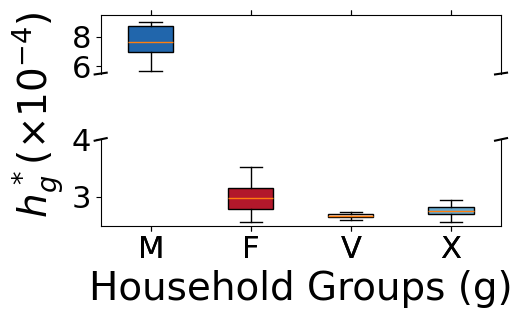

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

max_font_size = 34
rcParams["font.size"] = max_font_size
rcParams["axes.labelsize"] = max_font_size-6
rcParams["axes.titlesize"] = max_font_size-6
rcParams["xtick.labelsize"] = max_font_size-12
rcParams["ytick.labelsize"] = max_font_size-12

#fig,ax = plt.subplots(figsize=(6,8))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 4), gridspec_kw={'height_ratios': [1.7, 2.5]})

colors = ['#2166ac','#b2182b','#ef8a62','#fddbc7','#d1e5f0','#67a9cf']
colors = ['#2166ac','#b2182b','#fddbc7','#67a9cf']
colors = ['#2166ac','#b2182b','#fddbc7','#67a9cf']
#colors = ['#2166ac']
groups = ['M','F','E','C','EC','X']
groups = ['M','F','V','X']
#groups = ['M']
bplot = ax1.boxplot(hazards[0:],
                   patch_artist=True,  # fill with color
                   tick_labels=groups[0:])  # will be used to label x-ticks

#ax1.set_xlabel('Household Classification (g)')
#ax1.set_ylabel('$h^*_g(\\times 10^{-4})$')
ax1.set_ylim([5.5,9.5]) 
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    
bplot = ax2.boxplot(hazards[0:],
                   patch_artist=True,  # fill with color
                   tick_labels=groups[0:])  # will be used to label x-ticks

#ax1.set_xlabel('Household Classification (g)')
#ax1.set_ylabel('$h^*_g(\\times 10^{-4})$')
ax2.set_ylim([2.5,4]) 
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax2.xaxis.tick_bottom()
d = 0.015  # Size of diagonal lines indicating break
kwargs = dict(transform=ax1.transAxes, color='black', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)  # Top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Top-right diagonal

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Bottom-right diagonal

ax2.set_ylabel('           $h^*_g(\\times 10^{-4})$')
ax2.set_xlabel('Household Groups (g)')
fig.tight_layout()
fig.savefig('Figures/Case-study-2.pdf',bbox_inches='tight',dpi=350)
#plt.show()

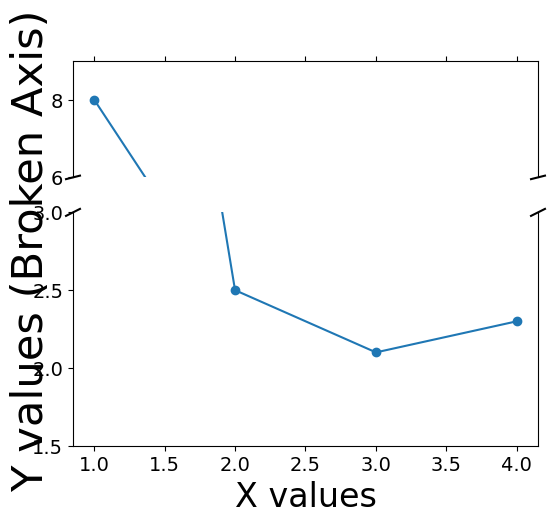

In [34]:
import matplotlib.pyplot as plt
import numpy as np

x = [1, 2, 3, 4]
y = [8, 2.5, 2.1, 2.3]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 5), gridspec_kw={'height_ratios': [1, 2]})

# Upper plot (showing the first value)
ax1.plot(x, y, marker='o', linestyle='-')
ax1.set_ylim(6, 9)  # Limit the upper part

# Lower plot (zoomed in on the last three values)
ax2.plot(x, y, marker='o', linestyle='-')
ax2.set_ylim(1.5, 3)  # Focus on the small differences

# Hide spines and add breaks
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax2.xaxis.tick_bottom()
d = 0.015  # Size of diagonal lines indicating break
kwargs = dict(transform=ax1.transAxes, color='black', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)  # Top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Top-right diagonal

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Bottom-right diagonal

plt.xlabel("X values")
fig.supylabel("Y values (Broken Axis)")
plt.show()
# 3. Normalize the Values for Better Visibility
# If preserving the exact values isn’t necessary, you can normalize the data to focus on relative differences.
# python
# Copy
# Edit
# import numpy as np
# import matplotlib.pyplot as plt

# x = [1, 2, 3, 4]
# y = [8, 2.5, 2.1, 2.3]

# # Normalize y-values
# y_normalized = [(val - min(y)) / (max(y) - min(y)) for val in y]

# plt.figure(figsize=(6, 4))
# plt.plot(x, y_normalized, marker='o', linestyle='-')
# plt.xlabel("X values")
# plt.ylabel("Normalized Y values")
# plt.title("Plot with Normalized Y-Values")
# plt.show()

In [23]:
def plot_sim_and_gt_for_dc(ax,sim_df,model_name,gt_df,lgd_params,conflict_data=None,gt_scale=1,add_error=0,
                    country_name='PL',date_start='2022-04-01',date_end='2022-08-01',top_k=1,not_plot_gt=0,coverage=0.5):
    #print('visualization for',model_name)
    base_color = '#08519c'
    cover_alpha_dict = {0.5:0.4,0.9:0.3,0.95:0.2}
    alpha = cover_alpha_dict[coverage] if coverage in cover_alpha_dict else 0.3
    ax.plot(sim_df['return_date'],sim_df['Total']/1000,alpha=1.0/top_k,color=base_color,linewidth=3)
    ax.fill_between(sim_df['return_date'],sim_df['q1']/1000,sim_df['q3']/1000,alpha=alpha/top_k,color=base_color,label='HazARD-'+str(int(coverage*100))+'% CI')
    if not not_plot_gt:
        ax.scatter(gt_df['return_date'][::7],gt_df['departure'][::7]/(1000*gt_scale),facecolor='none',edgecolor='black',s=200,label='Observed')
    
    if conflict_data is not None:
        print('plotting conflict data')
        ax2 = ax.twinx()
        ax2.plot(conflict_context['time'],conflict_context['conflict'],label='C(t)',color='red')
        
    ll,corr,err = compute_loss(sim_df, gt_df, 'departure',date_start,date_end,gt_scale=gt_scale)

    handles, labels = ax.get_legend_handles_labels()
    #print(labels)
    err_patch = mpatches.Patch(color='#ec7014', label='NRMSE: '+str(round(err,4)))
    corr_patch = mpatches.Patch(color='#41ab5d', label='PCC: '+str(round(corr,4)))
    
    if add_error:
        handles.extend([err_patch,corr_patch])
        #handles.append(corr_patch)
        handles, labels = ax.get_legend_handles_labels()
        #print('after error adding')
        #print(labels)
    
    myFmt = mdates.DateFormatter('%m/%d')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0,interval=4))
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_xlim([pd.to_datetime(date_start),pd.to_datetime(date_end)])
    ax.legend(loc="best", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
                 handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
                 ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=True, 
                 prop={'size': lgd_params['size']})
    ax.set_ylabel('Returnee (K)')
    #ax.set_title(model_name)
    #ax.set_xlabel('Date')
    
    props = {"rotation" : 0}
    plt.setp(ax.get_xticklabels(), **props)


COUNTRY: POLAND, MODEL: {} ConstHaz
crps 0.06650725234040986

COUNTRY: POLAND, MODEL: {} $GC_{21}^{14}$
crps 0.059269806731064294

COUNTRY: POLAND, MODEL: {} $GC_{21}^{14}-Peer$
crps 0.056661620973003576

COUNTRY: POLAND, MODEL: {} $GC_{30}^{7}-Peer$
crps 0.05093883708209886

COUNTRY: POLAND, MODEL: {} $GC_{35}^{7}-Peer$
crps 0.05239513358499111

COUNTRY: POLAND, MODEL: {} $GC_{40}^{7}-Peer$
crps 0.05630964267201976

COUNTRY: POLAND, MODEL: {} $GC_{45}^{7}-Peer$
crps 0.05781080328118643


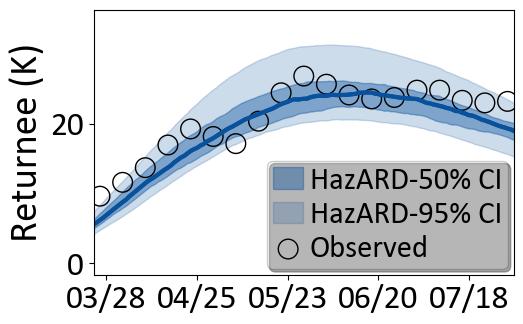

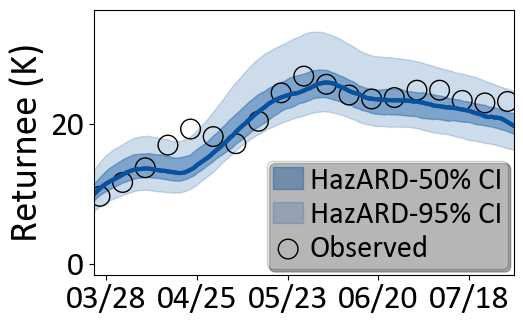

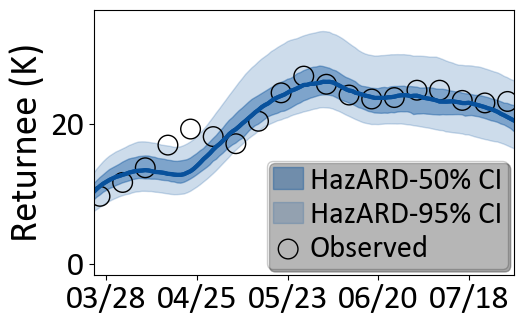

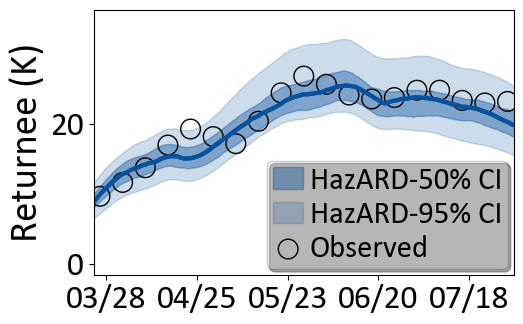

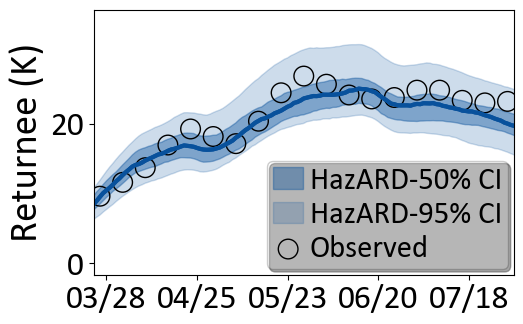

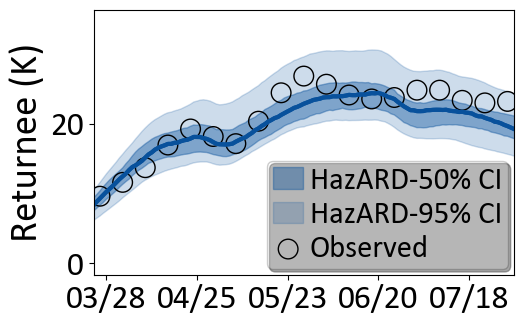

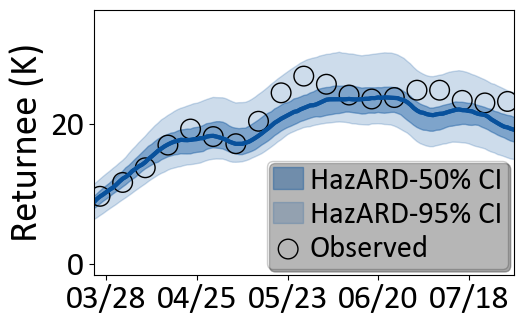

In [24]:
from matplotlib import rcParams

# max_font_size = 32
# rcParams["font.size"] = max_font_size
# rcParams["axes.labelsize"] = max_font_size-2
# rcParams["axes.titlesize"] = max_font_size-2
# rcParams["xtick.labelsize"] = max_font_size-8
# rcParams["ytick.labelsize"] = max_font_size-8

rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 24
rcParams["ytick.labelsize"] = 24

import matplotlib.dates as mdates
lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':1,
              'ecolor':'black','size':22,'alpha':0.2}

def scale_purifier(val,lb=0.95,rb=1.05):
    return max(lb,min(val,rb))

covers = []

result_dict = []

fig_model_names = ['const','gc_21','gc_21_peer','gc_30_peer','gc_35_peer','gc_40_peer','gc_45_peer']

for iddd in range(len(dir_name)):
    #if iddd==1:
    #    continue
    #
    fig,ax = plt.subplots(figsize=(6,4))
    #fig,ax = plt.subplots(figsize=(5,4))
    off = 1
    
    
    print('\nCOUNTRY: POLAND, MODEL: {}',modeltypes[iddd])
    for modelk in range(TOPK):
        all_sim_df = get_all_estimation(str(min_observe_idx[iddd][modelk]+off).zfill(9),dir_name[iddd],all_raions,'PL',cache_clean_mode=0)
        crps = get_crps(all_sim_df,ukr_people_depart_poland_by_date,'departure','2022-03-24','2022-08-01')
        #print(crps_df.head())
        print('crps',crps)
        sim_df_1 = get_estimation_Q1_Q3(str(min_observe_idx[iddd][modelk]+off).zfill(9),dir_name[iddd],all_raions,'PL',cache_clean_mode=0,alpha=0.5)
        sim_df_2 = get_estimation_Q1_Q3(str(min_observe_idx[iddd][modelk]+off).zfill(9),dir_name[iddd],all_raions,'PL',cache_clean_mode=0,alpha=0.9)
        #opt_scale = get_opt_scale(sim_df_1, ukr_people_depart_poland_by_date, 'departure', '2022-04-01', '2022-08-01')
        #print('optimum scale',opt_scale)
        #opt_scale = 1
        plot_sim_and_gt_for_dc(ax,sim_df_1,modeltypes[iddd],ukr_people_depart_poland_by_date,lgd_params,
                        top_k=TOPK,gt_scale=scale_purifier(1),not_plot_gt=1,add_error=0,date_start='2022-03-24',date_end='2022-08-01')
        plot_sim_and_gt_for_dc(ax,sim_df_2,modeltypes[iddd],ukr_people_depart_poland_by_date,lgd_params,
                        top_k=TOPK,gt_scale=scale_purifier(1),not_plot_gt=modelk,coverage=0.95,date_start='2022-03-24',date_end='2022-08-01')
        #corr,err = plot_error(ax,sim_df_1,'',ukr_people_depart_poland_by_date,lgd_params,date_start='2022-03-24',date_end='2022-08-01')
        # alphas = [0.05,0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]
        # result_dict.append({'model':modeltypes[iddd],'crps':crps,'nrmse':err,'corr':corr})
        # covers = []
        # for alpha in alphas:
        #     sim_df = get_estimation_Q1_Q3(str(min_observe_idx[iddd][modelk]+off).zfill(9),dir_name[iddd],all_raions,'PL',cache_clean_mode=0,
        #                             alpha=alpha)
        #     cover = get_CI_coverage(sim_df,ukr_people_depart_poland_by_date,'departure','2022-03-24','2022-08-01')
        #     covers.append(cover)
        #     #print(alpha,'',cover)
        # ax[1].plot(alphas,covers,marker='o',linewidth=4,color='#525252',markersize=20)
        # ax[1].plot(alphas,alphas,linewidth=1,color='gray')
        # ax[1].set_xlim([0,1.0])
        # ax[1].set_ylim([0,1.05])
        #ax[1].set_title('Nominal Interval Coverage')
        
        
#     print('\nCOUNTRY: SLOVAKIA, MODEL: {}',modeltypes[iddd])
#     for modelk in range(TOPK):
#         sim_df_2 = get_estimation(str(min_observe_idx[iddd][modelk]+off).zfill(9),dir_name[iddd],all_raions,'SK',cache_clean_mode=0)
#         opt_scale = get_opt_scale(sim_df_2, svk_ukr_depart_df, 'departure', '2022-03-24', '2022-08-01')
#         #print('optimum scale',opt_scale)
#         #opt_scale = 1
#         plot_sim_and_gt(ax[1],sim_df_2,modeltypes[iddd]+' : model '+str(modelk),svk_ukr_depart_df,lgd_params,
#                         top_k=TOPK,gt_scale=scale_purifier(opt_scale),country_name='SK',not_plot_gt=modelk)
        
#     print('\nCOUNTRY: ROMANIA, MODEL: {}',modeltypes[iddd])
#     for modelk in range(TOPK):
#         sim_df_3 = get_estimation(str(min_observe_idx[iddd][modelk]+off).zfill(9),dir_name[iddd],all_raions,'RO',cache_clean_mode=0)
#         opt_scale = get_opt_scale(sim_df_3, rom_ukr_depart_df, 'departure', '2022-03-24', '2022-07-24')
#         #print('optimum scale',opt_scale)
#         #opt_scale = 1
#         plot_sim_and_gt(ax[2],sim_df_3,modeltypes[iddd]+' : model '+str(modelk),rom_ukr_depart_df,lgd_params,
#                         top_k=TOPK,gt_scale=scale_purifier(opt_scale),country_name='RO',not_plot_gt=modelk)

    #extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    
    
    #extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    #fig.savefig('Figures/'+fig_model_names[iddd]+'_nominal_coverage.png', bbox_inches=extent.expanded(1.3, 1.2),dpi=350)
    fig.tight_layout()
    fig.savefig('Figures/'+fig_model_names[iddd]+'_return_estimation.png', bbox_inches='tight',dpi=350)



COUNTRY: POLAND, MODEL: {} ConstHaz
crps 0.06650725234040986

COUNTRY: POLAND, MODEL: {} $GC_{21}^{14}$
crps 0.059269806731064294

COUNTRY: POLAND, MODEL: {} $GC_{21}^{14}-Peer$
crps 0.056661620973003576

COUNTRY: POLAND, MODEL: {} $GC_{30}^{7}-Peer$
crps 0.05093883708209886

COUNTRY: POLAND, MODEL: {} $GC_{35}^{7}-Peer$
crps 0.05239513358499111

COUNTRY: POLAND, MODEL: {} $GC_{40}^{7}-Peer$
crps 0.05630964267201976


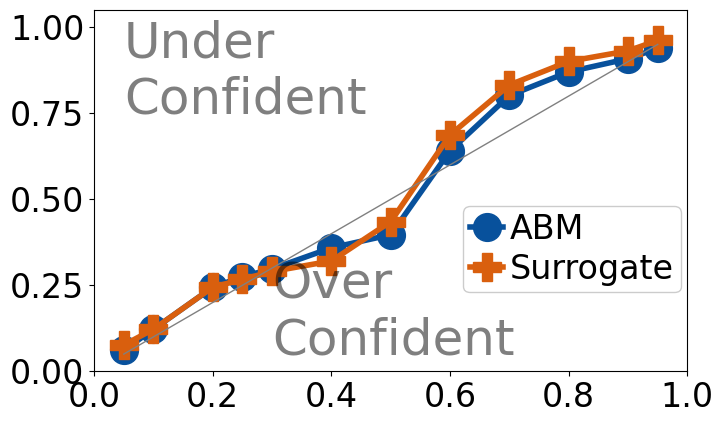

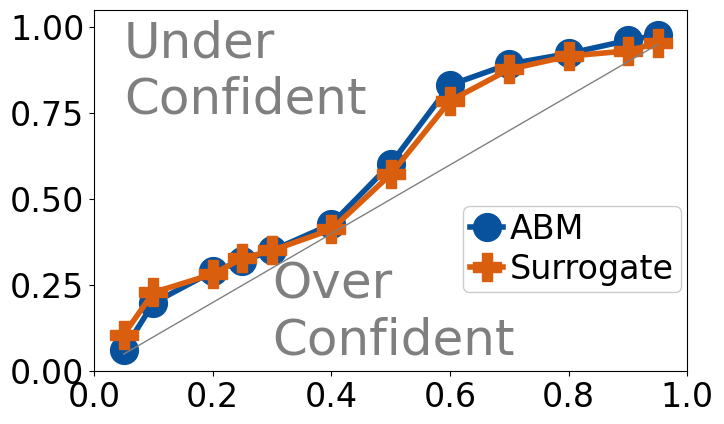

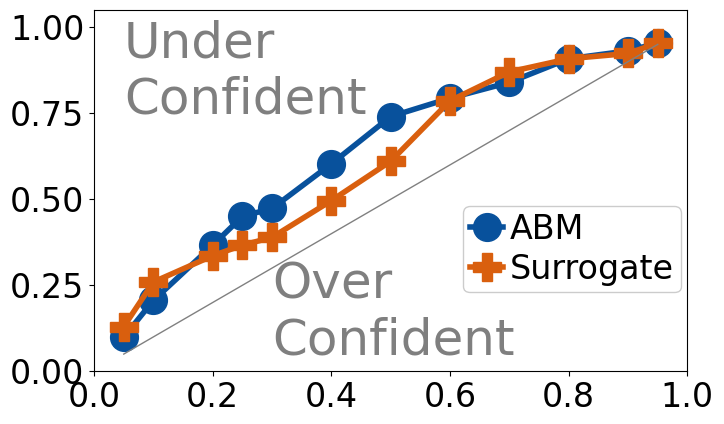

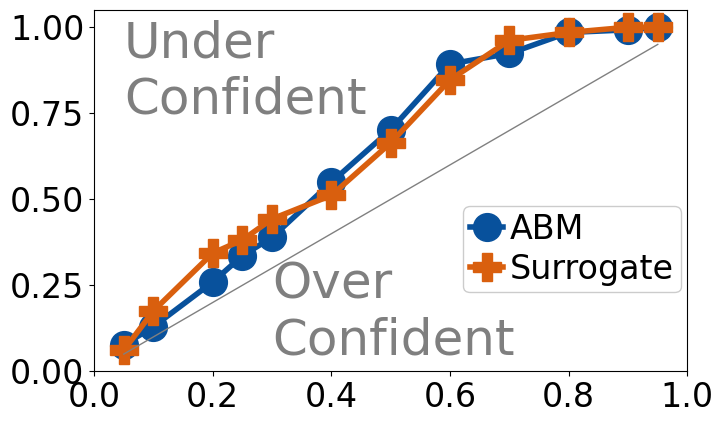

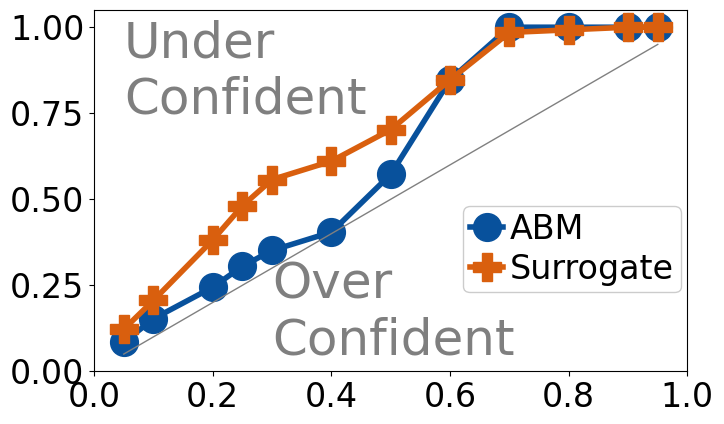

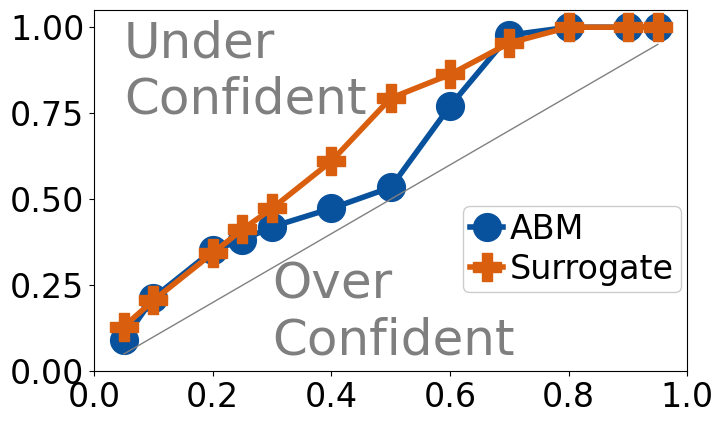

In [10]:
from matplotlib import rcParams

max_font_size = 32
rcParams["font.size"] = max_font_size
rcParams["axes.labelsize"] = max_font_size-2
rcParams["axes.titlesize"] = max_font_size-2
rcParams["xtick.labelsize"] = max_font_size-8
rcParams["ytick.labelsize"] = max_font_size-8


import matplotlib.dates as mdates
lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':1,
              'ecolor':'black','size':24,'alpha':0.2}

def scale_purifier(val,lb=0.95,rb=1.05):
    return max(lb,min(val,rb))

covers = []

result_dict = []

fig_model_names = ['const','gc_21','gc_21_peer','gc_30_peer','gc_35_peer','gc_40_peer','gc_45_peer']

s_df = pd.read_csv('s-ci-coverage.csv') 

for iddd in range(len(fig_model_names)):
    #if iddd==1:
    #    continue
    #
    fig,ax = plt.subplots(figsize=(8,5))
    #fig,ax = plt.subplots(figsize=(5,4))
    off = 1
    
    
    print('\nCOUNTRY: POLAND, MODEL: {}',modeltypes[iddd])
    for modelk in range(TOPK):
        all_sim_df = get_all_estimation(str(min_observe_idx[iddd][modelk]+off).zfill(9),dir_name[iddd],all_raions,'PL',cache_clean_mode=0)
        crps = get_crps(all_sim_df,ukr_people_depart_poland_by_date,'departure','2022-03-24','2022-08-01')
        #print(crps_df.head())
        print('crps',crps)
        sim_df_1 = get_estimation_Q1_Q3(str(min_observe_idx[iddd][modelk]+off).zfill(9),dir_name[iddd],all_raions,'PL',cache_clean_mode=0,alpha=0.5)
        sim_df_2 = get_estimation_Q1_Q3(str(min_observe_idx[iddd][modelk]+off).zfill(9),dir_name[iddd],all_raions,'PL',cache_clean_mode=0,alpha=0.9)
        #opt_scale = get_opt_scale(sim_df_1, ukr_people_depart_poland_by_date, 'departure', '2022-04-01', '2022-08-01')
        #print('optimum scale',opt_scale)
        #opt_scale = 1
        #plot_sim_and_gt(ax,sim_df_1,modeltypes[iddd],ukr_people_depart_poland_by_date,lgd_params,
        #                top_k=TOPK,gt_scale=scale_purifier(1),not_plot_gt=modelk,add_error=1,date_start='2022-03-24',date_end='2022-08-01')
        #plot_sim_and_gt(ax,sim_df_2,modeltypes[iddd],ukr_people_depart_poland_by_date,lgd_params,
        #                top_k=TOPK,gt_scale=scale_purifier(1),not_plot_gt=modelk,coverage=0.95,date_start='2022-03-24',date_end='2022-08-01')
        #corr,err = plot_error(ax,sim_df_1,'',ukr_people_depart_poland_by_date,lgd_params,date_start='2022-03-24',date_end='2022-08-01')
        alphas = [0.05,0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]
        result_dict.append({'model':modeltypes[iddd],'crps':crps,'nrmse':err,'corr':corr})
        covers = []
        for alpha in alphas:
            sim_df = get_estimation_Q1_Q3(str(min_observe_idx[iddd][modelk]+off).zfill(9),dir_name[iddd],all_raions,'PL',cache_clean_mode=0,
                                    alpha=alpha)
            cover = get_CI_coverage(sim_df,ukr_people_depart_poland_by_date,'departure','2022-03-24','2022-08-01')
            covers.append(cover)
            #print(alpha,'',cover)
        ax.plot(alphas,covers,marker='o',linewidth=4,color='#08519c',markersize=20,label='ABM')
        ax.plot(alphas,s_df[fig_model_names[iddd]],marker='P',linewidth=4,color='#d95f0e',markersize=20,label='Surrogate')
        ax.plot(alphas,alphas,linewidth=1,color='gray')
        ax.set_xlim([0,1.0])
        ax.set_ylim([0,1.05])
        ax.text(0.05, 0.75, 'Under\nConfident', fontsize = 36,alpha=0.5)
        ax.text(0.3, 0.05, 'Over\nConfident', fontsize = 36,alpha=0.5)
        #ax[1].set_title('Nominal Interval Coverage')
        
    ax.legend(loc="lower right", bbox_to_anchor=(1, 0.2),fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
             handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
             ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=False, 
             prop={'size': lgd_params['size']})
#     print('\nCOUNTRY: SLOVAKIA, MODEL: {}',modeltypes[iddd])
#     for modelk in range(TOPK):
#         sim_df_2 = get_estimation(str(min_observe_idx[iddd][modelk]+off).zfill(9),dir_name[iddd],all_raions,'SK',cache_clean_mode=0)
#         opt_scale = get_opt_scale(sim_df_2, svk_ukr_depart_df, 'departure', '2022-03-24', '2022-08-01')
#         #print('optimum scale',opt_scale)
#         #opt_scale = 1
#         plot_sim_and_gt(ax[1],sim_df_2,modeltypes[iddd]+' : model '+str(modelk),svk_ukr_depart_df,lgd_params,
#                         top_k=TOPK,gt_scale=scale_purifier(opt_scale),country_name='SK',not_plot_gt=modelk)
        
#     print('\nCOUNTRY: ROMANIA, MODEL: {}',modeltypes[iddd])
#     for modelk in range(TOPK):
#         sim_df_3 = get_estimation(str(min_observe_idx[iddd][modelk]+off).zfill(9),dir_name[iddd],all_raions,'RO',cache_clean_mode=0)
#         opt_scale = get_opt_scale(sim_df_3, rom_ukr_depart_df, 'departure', '2022-03-24', '2022-07-24')
#         #print('optimum scale',opt_scale)
#         #opt_scale = 1
#         plot_sim_and_gt(ax[2],sim_df_3,modeltypes[iddd]+' : model '+str(modelk),rom_ukr_depart_df,lgd_params,
#                         top_k=TOPK,gt_scale=scale_purifier(opt_scale),country_name='RO',not_plot_gt=modelk)

    #extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    
    
    #extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    #fig.savefig('Figures/'+fig_model_names[iddd]+'_nominal_coverage.png', bbox_inches=extent.expanded(1.3, 1.2),dpi=350)
    fig.tight_layout()
    fig.savefig('Figures/'+fig_model_names[iddd]+'_nominal_coverage.png', bbox_inches='tight',dpi=350)


In [16]:
df = pd.read_parquet('/project/biocomplexity/UKR_forecast/migration_data/output_data_2024/RETURN_HAZARD_Bayesian_opt3_constant_000000001/mim_hid_return_Bakhmutskyi_SIM_000000023_SEED_0.pq')

In [17]:
df['return_date'] = pd.to_datetime(df['return_date'])
df['move_date'] = pd.to_datetime(df['move_date'])
df['return_time'] = ((df['return_date']-df['move_date']).dt.days)
return_time_df = df.groupby('return_time')['hid'].count().reset_index()
return_time_df

,return_time,hid
0,0,4
1,1,16
2,2,23
3,3,23
4,4,27
...,...,...
183,183,5
184,184,3
185,186,4
186,187,2


In [22]:
def get_return_time_estimate(param,return_dir_prefix,all_raions,dest_name,Q1=0.2,Q3=0.8,cache_clean_mode=0):
    print(Q1,Q3)
    RETURN_DIR = f'{OUTPUT_DIR}{return_dir_prefix}_{param}/'
    cache_file_name = f'return_time_est_from_{dest_name}_to_UKR_method_{return_dir_prefix}_from_{param}.pq'
    if os.path.isfile(CACHE_DIR+cache_file_name) and cache_clean_mode==0:
        df = pd.read_parquet(CACHE_DIR+cache_file_name)
        return df 
    print('No file called',CACHE_DIR+cache_file_name,'calculating...')
    single_sim_return_df = []
    for sim in range(0,100):
        print(sim,end=',')
        sim_idx = str(sim).zfill(9)
        base_file = f'mim_hid_return_Kyiv_SIM_{sim_idx}_SEED_0.csv'
        base_file_fast = f'mim_hid_return_Kyiv_SIM_{sim_idx}_SEED_0.pq'
        #print('base_file_loc',RETURN_DIR+base_file,'khujtesi')
        #print('try to find either',RETURN_DIR+base_file,'or',RETURN_DIR+base_file_fast)
        if os.path.isfile(RETURN_DIR+base_file) or os.path.isfile(RETURN_DIR+base_file_fast):
            #print('found either',RETURN_DIR+base_file,'or',RETURN_DIR+base_file_fast)
            cur_settings_df = []
            for raion_name in all_raions:
                #print(raion_name)
                fname = f'mim_hid_return_{raion_name}_SIM_{sim_idx}_SEED_0.csv'
                fname_faster = f'mim_hid_return_{raion_name}_SIM_{sim_idx}_SEED_0.pq'
                #print('looking for',RETURN_DIR+fname_faster,flush=True)
                if os.path.isfile(RETURN_DIR+fname_faster):
                    #print(RETURN_DIR+fname_faster,'found',flush=True)
                    df = pd.read_parquet(RETURN_DIR+fname_faster)
                    df = df[df.dest==dest_name]
                    cur_settings_df.append(df)
                elif os.path.isfile(RETURN_DIR+fname):
                    df = pd.read_csv(RETURN_DIR+fname)
                    df.to_parquet(RETURN_DIR+fname_faster,index=False)
                    df = df[df.dest==dest_name]
                    cur_settings_df.append(df)
            #print('gathered',len(cur_settings_df),'results for',sim_idx,'in',RETURN_DIR,flush=True)
            if len(cur_settings_df)>0:
                all_return_df = pd.concat(cur_settings_df)
                #print(all_return_df.columns.tolist())
                all_return_df['return_date'] = pd.to_datetime(all_return_df['return_date'])
                all_return_df['move_date'] = pd.to_datetime(all_return_df['move_date'])
                all_return_df['return_time'] = ((all_return_df['return_date']-all_return_df['move_date']).dt.days)
                return_time_df = all_return_df.groupby('return_time')['hid'].count().reset_index()
                single_sim_return_df.append(return_time_df)
    return_time_ensemble_df = (pd.concat(single_sim_return_df)).groupby('return_time')['hid'].sum().reset_index()
    return_time_ensemble_df.to_parquet(CACHE_DIR+cache_file_name,index=False)
    return return_time_ensemble_df

In [23]:
def get_return_time_estimate_between_date(param,return_dir_prefix,all_raions,dest_name,Q1=0.2,Q3=0.8,cache_clean_mode=0,date_start='2022-04-01',date_end='2022-08-01'):
    print(Q1,Q3)
    RETURN_DIR = f'{OUTPUT_DIR}{return_dir_prefix}_{param}/'
    cache_file_name = f'return_time_est_between_{date_start}_and_{date_end}_from_{dest_name}_to_UKR_method_{return_dir_prefix}_from_{param}.pq'
    if os.path.isfile(CACHE_DIR+cache_file_name) and cache_clean_mode==0:
        df = pd.read_parquet(CACHE_DIR+cache_file_name)
        return df 
    print('No file called',CACHE_DIR+cache_file_name,'calculating...')
    single_sim_return_df = []
    for sim in range(0,100):
        print(sim,end=',')
        sim_idx = str(sim).zfill(9)
        base_file = f'mim_hid_return_Kyiv_SIM_{sim_idx}_SEED_0.csv'
        base_file_fast = f'mim_hid_return_Kyiv_SIM_{sim_idx}_SEED_0.pq'
        #print('base_file_loc',RETURN_DIR+base_file,'khujtesi')
        #print('try to find either',RETURN_DIR+base_file,'or',RETURN_DIR+base_file_fast)
        if os.path.isfile(RETURN_DIR+base_file) or os.path.isfile(RETURN_DIR+base_file_fast):
            #print('found either',RETURN_DIR+base_file,'or',RETURN_DIR+base_file_fast)
            cur_settings_df = []
            for raion_name in all_raions:
                #print(raion_name)
                fname = f'mim_hid_return_{raion_name}_SIM_{sim_idx}_SEED_0.csv'
                fname_faster = f'mim_hid_return_{raion_name}_SIM_{sim_idx}_SEED_0.pq'
                #print('looking for',RETURN_DIR+fname_faster,flush=True)
                if os.path.isfile(RETURN_DIR+fname_faster):
                    #print(RETURN_DIR+fname_faster,'found',flush=True)
                    df = pd.read_parquet(RETURN_DIR+fname_faster)
                    df = df[df.dest==dest_name]
                    cur_settings_df.append(df)
                elif os.path.isfile(RETURN_DIR+fname):
                    df = pd.read_csv(RETURN_DIR+fname)
                    df.to_parquet(RETURN_DIR+fname_faster,index=False)
                    df = df[df.dest==dest_name]
                    cur_settings_df.append(df)
            #print('gathered',len(cur_settings_df),'results for',sim_idx,'in',RETURN_DIR,flush=True)
            if len(cur_settings_df)>0:
                all_return_df = pd.concat(cur_settings_df)
                #print(all_return_df.columns.tolist())
                all_return_df['return_date'] = pd.to_datetime(all_return_df['return_date'])
                all_return_df = all_return_df[all_return_df.return_date>=pd.to_datetime(date_start)]
                all_return_df = all_return_df[all_return_df.return_date<=pd.to_datetime(date_end)]
                all_return_df['move_date'] = pd.to_datetime(all_return_df['move_date'])
                all_return_df['return_time'] = ((all_return_df['return_date']-all_return_df['move_date']).dt.days)
                return_time_df = all_return_df.groupby('return_time')['hid'].count().reset_index()
                single_sim_return_df.append(return_time_df)
    return_time_ensemble_df = (pd.concat(single_sim_return_df)).groupby('return_time')['hid'].sum().reset_index()
    return_time_ensemble_df.to_parquet(CACHE_DIR+cache_file_name,index=False)
    return return_time_ensemble_df

In [24]:
def get_return_time_series_estimate(param,return_dir_prefix,all_raions,dest_name,Q1=0.2,Q3=0.8,cache_clean_mode=0):
    print(Q1,Q3)
    RETURN_DIR = f'{OUTPUT_DIR}{return_dir_prefix}_{param}/'
    cache_file_name = f'return_time_series_mean_dev_est_from_{dest_name}_to_UKR_method_{return_dir_prefix}_from_{param}.pq'
    if os.path.isfile(CACHE_DIR+cache_file_name) and cache_clean_mode==0:
        df = pd.read_parquet(CACHE_DIR+cache_file_name)
        df['return_date'] = pd.to_datetime(df['return_date'])
        return df 
    print('No file called',CACHE_DIR+cache_file_name,'calculating...')
    single_sim_return_df = []
    for sim in range(0,100):
        print(sim,end=',')
        sim_idx = str(sim).zfill(9)
        base_file = f'mim_hid_return_Kyiv_SIM_{sim_idx}_SEED_0.csv'
        base_file_fast = f'mim_hid_return_Kyiv_SIM_{sim_idx}_SEED_0.pq'
        #print('base_file_loc',RETURN_DIR+base_file,'khujtesi')
        #print('try to find either',RETURN_DIR+base_file,'or',RETURN_DIR+base_file_fast)
        if os.path.isfile(RETURN_DIR+base_file) or os.path.isfile(RETURN_DIR+base_file_fast):
            #print('found either',RETURN_DIR+base_file,'or',RETURN_DIR+base_file_fast)
            cur_settings_df = []
            for raion_name in all_raions:
                #print(raion_name)
                fname = f'mim_hid_return_{raion_name}_SIM_{sim_idx}_SEED_0.csv'
                fname_faster = f'mim_hid_return_{raion_name}_SIM_{sim_idx}_SEED_0.pq'
                #print('looking for',RETURN_DIR+fname_faster,flush=True)
                if os.path.isfile(RETURN_DIR+fname_faster):
                    #print(RETURN_DIR+fname_faster,'found',flush=True)
                    df = pd.read_parquet(RETURN_DIR+fname_faster)
                    df = df[df.dest==dest_name]
                    cur_settings_df.append(df)
                elif os.path.isfile(RETURN_DIR+fname):
                    df = pd.read_csv(RETURN_DIR+fname)
                    df.to_parquet(RETURN_DIR+fname_faster,index=False)
                    df = df[df.dest==dest_name]
                    cur_settings_df.append(df)
            #print('gathered',len(cur_settings_df),'results for',sim_idx,'in',RETURN_DIR,flush=True)
            if len(cur_settings_df)>0:
                all_return_df = pd.concat(cur_settings_df)
                #print(all_return_df.columns.tolist())
                all_return_df['return_date'] = pd.to_datetime(all_return_df['return_date'])
                all_return_df['move_date'] = pd.to_datetime(all_return_df['move_date'])
                all_return_df['return_time'] = ((all_return_df['return_date']-all_return_df['move_date']).dt.days)
                single_sim_return_df.append(all_return_df[['return_date','return_time']])
    return_time_mean_df = ((pd.concat(single_sim_return_df)).groupby('return_date')['return_time'].mean().reset_index()).rename(columns={'return_time':'mean'})
    return_time_std_df = ((pd.concat(single_sim_return_df)).groupby('return_date')['return_time'].std().reset_index()).rename(columns={'return_time':'std'})
    return_time_series_df = return_time_mean_df.merge(return_time_std_df,on='return_date',how='inner')
    return_time_series_df.to_parquet(CACHE_DIR+cache_file_name,index=False)
    return return_time_series_df

In [25]:
[3]*5+[4]*2

[3, 3, 3, 3, 3, 4, 4]


COUNTRY: POLAND, MODEL: {} $GC_{30}^{7}-Peer$
0.2 0.8
0.2 0.8
0.2 0.8
0.2 0.8
0.2 0.8
0.2 0.8


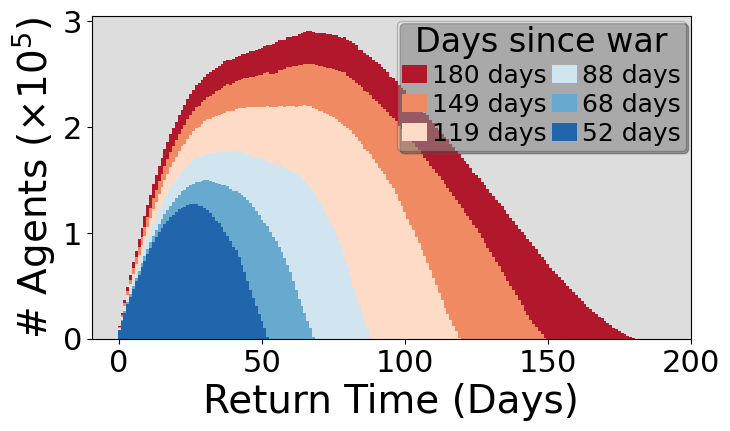

In [28]:
from matplotlib import rcParams

max_font_size = 30
rcParams["font.size"] = max_font_size
rcParams["axes.labelsize"] = max_font_size-2
rcParams["axes.titlesize"] = max_font_size-2
rcParams["legend.title_fontsize"] = max_font_size-6
rcParams["xtick.labelsize"] = max_font_size-8
rcParams["ytick.labelsize"] = max_font_size-8
rcParams['figure.facecolor'] = 'white'

import matplotlib.dates as mdates
lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':2,
              'ecolor':'black','size':18,'alpha':0.2}

def scale_purifier(val,lb=0.95,rb=1.05):
    return max(lb,min(val,rb))

covers = []

result_dict = []

fig_model_names = ['const','gc_21','gc_21_peer','gc_30_peer','gc_35_peer','gc_40_peer']


fig_colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']

fig_colors = ['#b2182b','#ef8a62','#fddbc7','#d1e5f0','#67a9cf','#2166ac']

widthval = 1

meantimes = []
meantimes_std = []
gt = [63,61,54,47,36,30]#[30,36,47,54,61,63]
TOPK = 1
for iddd in range(3,4):
#for iddd in range(2):
    off = 1
    fig,ax = plt.subplots(figsize=(8,5))
    ax.patch.set_facecolor('#dddddd')
    print('\nCOUNTRY: POLAND, MODEL: {}',modeltypes[iddd])
    for modelk in range(TOPK):
        
        for eidx,end_date in enumerate(['2022-08-23','2022-07-23','2022-06-23','2022-05-23','2022-05-03','2022-04-17']):
            days_passed = (pd.to_datetime(end_date)-pd.to_datetime('2022-02-24')).days
            
            return_time_series_df = get_return_time_estimate_between_date(str(min_observe_idx[iddd][modelk]+off).zfill(9),dir_name[iddd],
                                                                      all_raions,'PL',cache_clean_mode=0,date_start='2022-02-24',date_end=end_date)
            ax.bar(return_time_series_df['return_time'],return_time_series_df['hid']/1e5,alpha=1,color=fig_colors[eidx],width=widthval,label=str(days_passed)+' days')
            meantime = sum(return_time_series_df['return_time']*return_time_series_df['hid'])/sum(return_time_series_df['hid'])
            meantimes.append(meantime)
            stdtime = np.sqrt(sum((return_time_series_df['return_time']**2)*return_time_series_df['hid'])/sum(return_time_series_df['hid'])-meantime**2)
            meantimes_std.append(stdtime)
        
        ax.set_xlabel('Return Time (Days)')
        ax.set_ylabel('# Agents ($\\times 10^5$)')
        ax.set_xlim([None,200])
        #ax.set_ylim([None,4])
        ax.legend(loc="best",title='Days since war',fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
             handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
             ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=True, 
             prop={'size': lgd_params['size']})
    fig.tight_layout()
    #fig.savefig('Figures/Case-Study-1a.pdf',dpi=350,bbox_inches='tight')


COUNTRY: POLAND, MODEL: {} $GC_{30}^{7}-Peer$
0.2 0.8
0.2 0.8
0.2 0.8
0.2 0.8
0.2 0.8
0.2 0.8


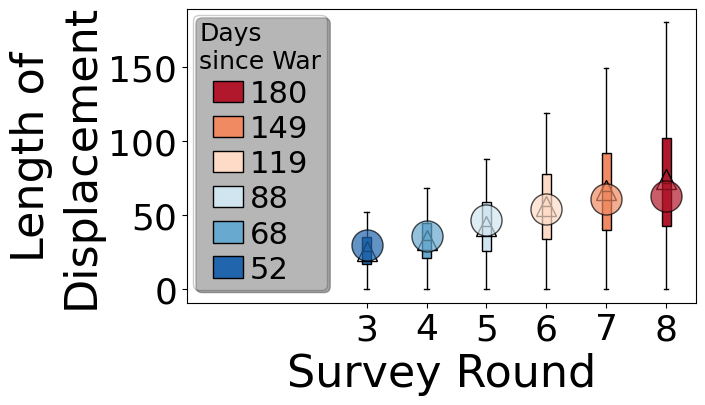

In [47]:
from matplotlib import rcParams

max_font_size = 38
rcParams["font.size"] = max_font_size
rcParams["axes.labelsize"] = max_font_size-6
rcParams["axes.titlesize"] = max_font_size-6
rcParams["xtick.labelsize"] = max_font_size-12
rcParams["ytick.labelsize"] = max_font_size-12
rcParams["legend.title_fontsize"] = max_font_size-20
rcParams['figure.facecolor'] = 'white'

import matplotlib.dates as mdates
lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':1,
              'ecolor':'black','size':22,'alpha':0.2}

def scale_purifier(val,lb=0.95,rb=1.05):
    return max(lb,min(val,rb))

covers = []

result_dict = []

fig_model_names = ['const','gc_21','gc_21_peer','gc_30_peer','gc_35_peer','gc_40_peer','gc_45_peer']


fig_colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']

fig_colors = ['#b2182b','#ef8a62','#fddbc7','#d1e5f0','#67a9cf','#2166ac']

widthval = 1

meantimes = []
meantimes_std = []
gt = [63,61,54,47,36,30]#[30,36,47,54,61,63]

for iddd in range(3,4):
#for iddd in range(2):
    off = 1
    fig,ax = plt.subplots(figsize=(8,5))
    
    #ax.patch.set_facecolor('#dddddd')
    print('\nCOUNTRY: POLAND, MODEL: {}',modeltypes[iddd])
    for modelk in range(TOPK):
        
        for eidx,end_date in enumerate(['2022-08-23','2022-07-23','2022-06-23','2022-05-23','2022-05-03','2022-04-17']):
            days_passed = (pd.to_datetime(end_date)-pd.to_datetime('2022-02-24')).days
            
            return_time_series_df = get_return_time_estimate_between_date(str(min_observe_idx[iddd][modelk]+off).zfill(9),dir_name[iddd],
                                                                      all_raions,'PL',cache_clean_mode=0,date_start='2022-02-24',date_end=end_date)
            
            
            expanded_values = np.repeat(return_time_series_df['return_time'], return_time_series_df['hid'])

            # Create a boxplot
            c = fig_colors[eidx]
            ax.boxplot(expanded_values, showmeans=True,positions=[8-eidx],patch_artist=True,
                boxprops=dict(facecolor=c, color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(color=c, markeredgecolor='black'),
                medianprops=dict(color='black'),
                meanprops={"marker": "^","color":c,
                "markeredgecolor": 'black',
                "markerfacecolor": 'none',
                "markersize": "15"},label=str(days_passed))
            ax.scatter([8-eidx],[gt[eidx]],facecolor=fig_colors[eidx],s=500,zorder=3,edgecolor='black',alpha=0.7)
        
    #ax.scatter([1,2,3,4,5],gt,s=500,edgecolor='black',facecolor='white',zorder=3)
    ax.legend(loc="best",title='Days\nsince War',fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
                 handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
                 ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=True, 
                 prop={'size': lgd_params['size']})
    ax.set_ylabel('Length of\nDisplacement')
    ax.set_xlabel('Survey Round')
    ax.set_xlim([0,None])
    fig.tight_layout()
    fig.savefig('Figures/Case-Study-1b.pdf',dpi=350,bbox_inches='tight')

In [57]:
mean

[66.83841137764851,
 56.45912315069082,
 42.956359514924145,
 33.143048586118326,
 25.574030682633534]

In [58]:
meantimes_std

[np.float64(33.68023359734112),
 np.float64(27.56900711789056),
 np.float64(20.576767016383616),
 np.float64(15.514724552176592),
 np.float64(11.686988613254979)]

In [59]:
gt

[30, 36, 47, 54, 61]

In [42]:
return_time_series_df

,return_time,hid
0,0,11772
1,1,23591
2,2,34827
3,3,46370
4,4,56818
...,...,...
185,185,3042
186,186,2188
187,187,1498
188,188,922


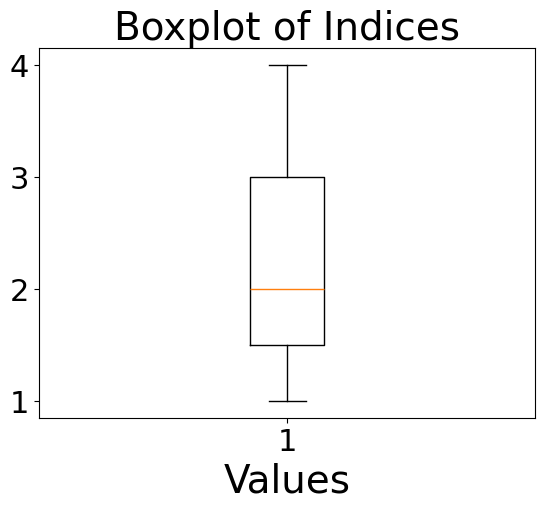

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Example pandas Series
data = pd.Series([1, 2, 2, 2, 2,2, 4, 4, 4, 4])

# Get value_counts()
value_counts = data.value_counts()

# Extract the indices (unique values from the original data)
indices = value_counts.index

# Create a boxplot
plt.boxplot(indices)  # `vert=False` creates a horizontal boxplot
plt.title('Boxplot of Indices')
plt.xlabel('Values')
plt.show()

In [63]:
value_counts

2    5
4    4
1    1
Name: count, dtype: int64

In [36]:
return_time_binned

,return_time,hid
0,"(-0.189, 18.9]",2720798
1,"(18.9, 37.8]",4242849
2,"(37.8, 56.7]",4907892
3,"(56.7, 75.6]",5185856
4,"(75.6, 94.5]",5090355
5,"(94.5, 113.4]",4319426
6,"(113.4, 132.3]",3214541
7,"(132.3, 151.2]",2066620
8,"(151.2, 170.1]",1012739
9,"(170.1, 189.0]",244498


In [15]:
## WIS score
## CRPS
## CI coverage

# https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008618

#https://arxiv.org/pdf/2205.07090

In [72]:
%%time
import imageio
import os

path = 'Figures/' # on Mac: right click on a folder, hold down option, and click "copy as pathname"

image_folder = os.fsencode(path)

filenames = []

for file in os.listdir(image_folder):
    filename = os.fsdecode(file)
    if filename.endswith( ('.jpeg', '.png') ):
        filenames.append('Figures/'+filename)

filenames.sort() # this iteration technique has no built in order, so sort the frames
print(filenames)
images = list(map(lambda filename: imageio.imread(filename), filenames))

imageio.mimsave(os.path.join('Figures/movie_bayes_opt.gif'), images, duration = 1000) # modify duration as needed


['Figures/const_haz_optimizer_state_after_it_10.png', 'Figures/const_haz_optimizer_state_after_it_11.png', 'Figures/const_haz_optimizer_state_after_it_12.png', 'Figures/const_haz_optimizer_state_after_it_13.png', 'Figures/const_haz_optimizer_state_after_it_14.png', 'Figures/const_haz_optimizer_state_after_it_15.png', 'Figures/const_haz_optimizer_state_after_it_16.png', 'Figures/const_haz_optimizer_state_after_it_17.png', 'Figures/const_haz_optimizer_state_after_it_18.png', 'Figures/const_haz_optimizer_state_after_it_19.png', 'Figures/const_haz_optimizer_state_after_it_20.png', 'Figures/const_haz_optimizer_state_after_it_21.png', 'Figures/const_haz_optimizer_state_after_it_22.png', 'Figures/const_haz_optimizer_state_after_it_23.png', 'Figures/const_haz_optimizer_state_after_it_24.png', 'Figures/const_haz_optimizer_state_after_it_25.png', 'Figures/const_haz_optimizer_state_after_it_26.png', 'Figures/const_haz_optimizer_state_after_it_27.png', 'Figures/const_haz_optimizer_state_after_it_2

## surrogate model

Roll = Scalar From input

Lag = Scalar from Input

M(t) = Aggregated number of outflow at time t

C(t) = Aggregated conflict context at time t by applying Lag-Roll on Raw conflict data

R(t) = Aggregated return at time t, Initially 0

ConstHazModel(h):
    
    for t in range(0,len(M)):
        
        Survival = 1.0
        
        past_t = t
        ## Analyze which people who had migrated previously can return at all times prior to t
        while(past_t>=0):
            Returnee_from_past = M[past_t]-M[past_t]*S 
            R[t] = R[t] + Returnee ## this many people from past will return at the current time
            M[past_t] = M[past_t] - Returnee ##less people remained to return from the past
            S = S*(1.0-h) # depending on choice of model this will be updated
            past_t = past_t - 1
            
ConflicHazModel(h):
    
    for t in range(0,len(M)):
        
        Survival = 1.0
        
        past_t = t
        ## Analyze which people who had migrated previously can return at all times prior to t
        while(past_t>=0):
            Returnee_from_past = M[past_t]-M[past_t]*S 
            R[t] = R[t] + Returnee ## this many people from past will return at the current time
            M[past_t] = M[past_t] - Returnee ##less people remained to return from the past
            S = S*(1.0-h*h*(1-C[past_t])) # depending on choice of model this will be updated
            past_t = past_t - 1